In [6]:

import numpy as np
import pandas as pd
import random
import shutil
import glob
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons  as tfa
from tensorflow.keras import Sequential, Model, layers, regularizers
from tensorflow.keras.layers import Conv2D, Dense, Input, Dropout, Activation, LeakyReLU, ReLU, BatchNormalization, Reshape, Flatten, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras.activations import relu, tanh
from keras.initializers import RandomNormal
from scipy import stats
import time


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
monet_tfrec_path = '../input/gan-getting-started/monet_tfrec'
monet_jpg_path = '../input/gan-getting-started/monet_jpg'
photo_tfrec_path = '../input/gan-getting-started/photo_tfrec'
photo_jpg_path = '../input/gan-getting-started/photo_jpg'

In [5]:

monet_tfrec = tf.io.gfile.glob(monet_tfrec_path+'/*.tfrec')
monet_jpg = tf.io.gfile.glob(monet_jpg_path+'/*.jpg')
photo_tfrec = tf.io.gfile.glob(photo_tfrec_path+'/*.tfrec')
photo_jpg = tf.io.gfile.glob(photo_jpg_path+'/*.jpg')

## Exploratory data analysis (EDA):

In [18]:
def load_img(path):
    img_path = tf.io.read_file(path)
    img_path = tf.image.decode_image(img_path, channels = 3)
    img_path = tf.image.convert_image_dtype(img_path, tf.float32)
    img_path = tf.reshape(img_path, [256, 256, 3])
    return img_path


def img_decode(path):
    imgs = tf.image.decode_image(path, channels = 3)
    imgs = (tf.cast(imgs, tf.float32) /127.5) - 1
    imgs = tf.reshape(imgs, [256, 256, 3])
    return imgs

def process_img(path):
    format = {
        'image_name': tf.io.FixedLenFeature([], tf.string),\
        'image' : tf.io.FixedLenFeature([], tf.string),\
        'target' : tf.io.FixedLenFeature([], tf.string) }
    
    paths = tf.io.parse_single_example(path, format)
    img = img_decode(paths['image'])
    return img

def load_dat(name):
    dataset = tf.data.TFRecordDataset(name)
    dataset = dataset.map(process_img, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    return dataset

def crop(image, box):
    img = Image.open(image)
    img = img.crop(box)
    return img


In [19]:

monet_data = load_dat(monet_tfrec).batch(1)
photo_data = load_dat(photo_tfrec).batch(1)

### Visulaization

(-0.5, 255.5, 255.5, -0.5)

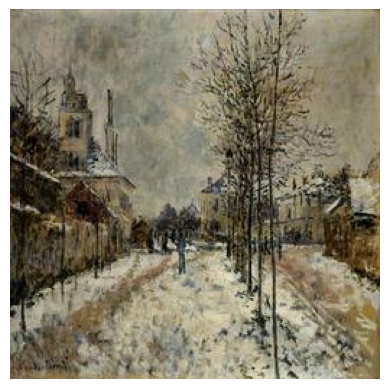

In [20]:
sample = next(iter(monet_data))
plt.imshow(sample[0]*0.5 + 0.5)
plt.axis('off')

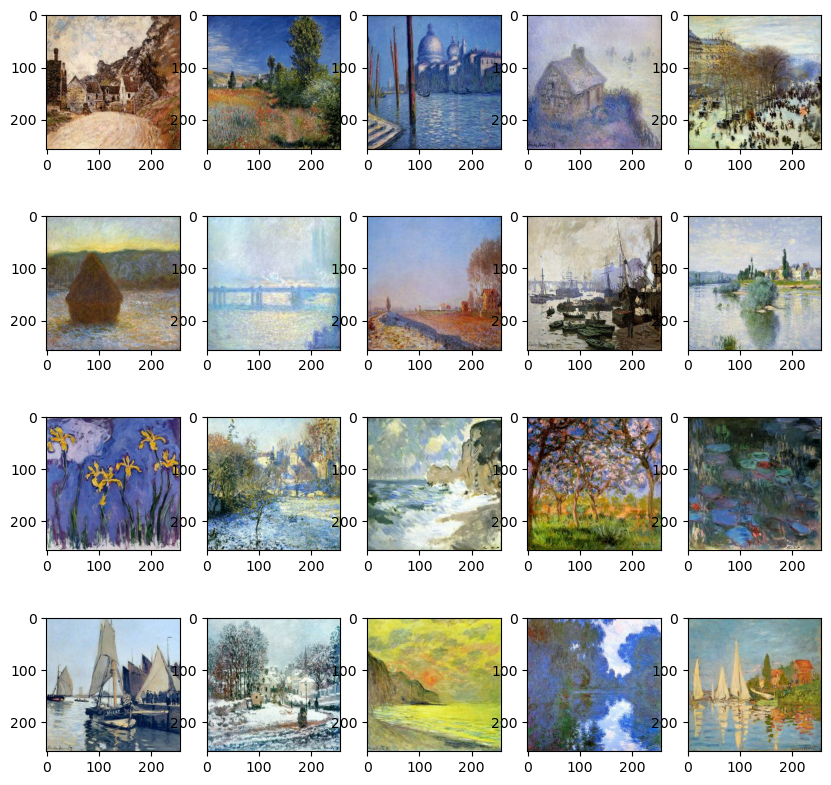

In [23]:
fig, ax = plt.subplots(4, 5, figsize = (10, 10))
jpg = random.sample(monet_jpg, 20)
for idx, name in enumerate(jpg):
    img = load_img(name)
    ax[idx//5, idx%5].imshow(img)

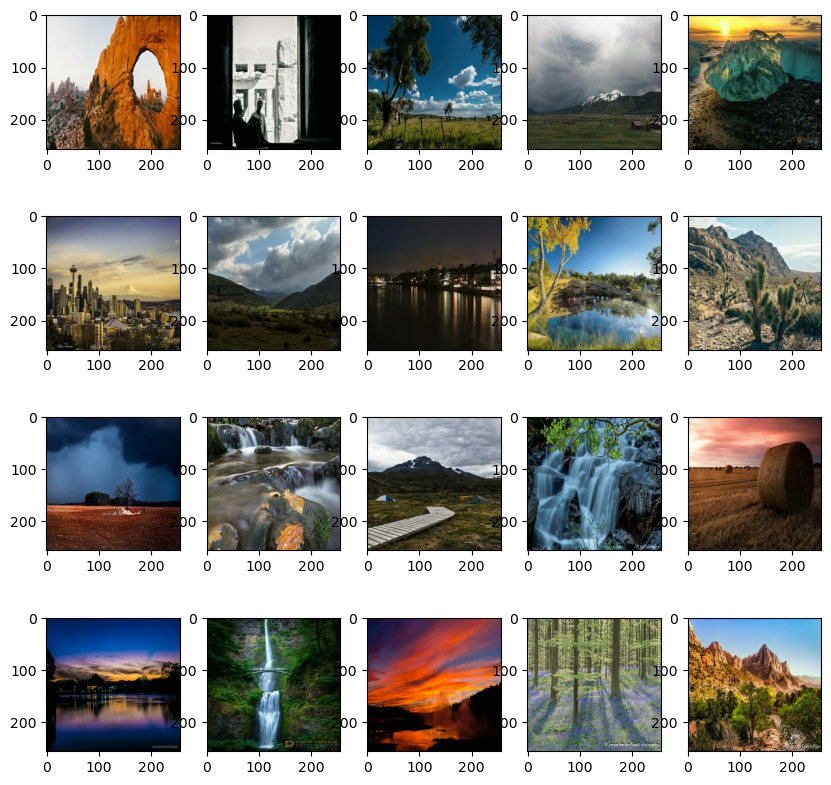

In [25]:
fig, ax = plt.subplots(4, 5, figsize = (10, 10))
jpg = random.sample(photo_jpg, 20)
for idx, name in enumerate(jpg):
    img = load_img(name)
    ax[idx//5, idx%5].imshow(img)

## model building

In [33]:
# model from amy yang
def model():
    init  = RandomNormal(mean = 0, stddev = 0.02)
    
    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, input_shape = [256, 256, 3], kernel_initializer = init))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #model.add(Reshape((8, 8, 512)))

    model.add(Conv2D(filters = 128, kernel_size = (4, 4), strides = (2, 2), padding = 'same', use_bias = False, kernel_initializer = init))
    model.add(BatchNormalization())
    model.add(LeakyReLU())    
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 256, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = init))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))


    model.add(Conv2DTranspose(filters = 265, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = init))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = init))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    model.add(Conv2DTranspose(filters = 3, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = init))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    return model

In [34]:
# from amy yang
def discriminator_model():
    initializer  = RandomNormal(mean = 0, stddev = 0.02)
    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (4, 4), strides = (2,2), padding = 'same', input_shape = [256,256,3], kernel_initializer = initializer, use_bias = False))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 128, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 256, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(ReLU())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 1, kernel_size = (4, 4), strides = (2,2), padding = 'same', use_bias = False, kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    

    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    model.add(Flatten())
       
    return model
    

In [35]:

optimizer = Adam(0.0001)
generator = model()
generator.compile(loss = 'binarycrossentropy', optimizer = optimizer, metrics = ['accuracy'])
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      3072      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131072    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)      

In [37]:

discriminator = discriminator_model()
discriminator.compile(loss = 'binarycrossentropy', optimizer = optimizer, metrics = ['accuracy'])
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      3072      
                                                                 
 re_lu_3 (ReLU)              (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_10 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       131072    
                                                                 
 re_lu_4 (ReLU)              (None, 64, 64, 128)       0         
                                                      

In [42]:

optimizer = Adam(0.0001)

def gan_model(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


generator = model()
discriminator = discriminator_model()

GAN = gan_model(generator, discriminator)
GAN.compile(loss = 'binarycrossentropy', optimizer = optimizer, metrics = ['accuracy'])
GAN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 256, 256, 3)       2296112   
                                                                 
 sequential_7 (Sequential)   (None, 1)                 664581    
                                                                 
Total params: 2,960,693
Trainable params: 2,958,107
Non-trainable params: 2,586
_________________________________________________________________


(1, 256, 256, 3)
(256, 256)


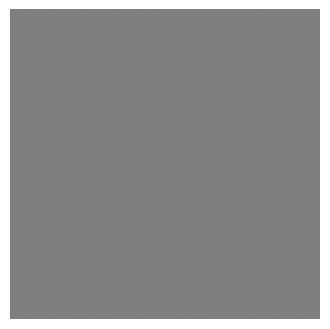

In [45]:

noise = tf.random.normal([1,256, 256, 3])
img = generator(noise)
generated_image = generator(noise, training = False)
print(generated_image.shape)
print(generated_image[0, :, :, 0].shape)

def gen_imgs(row = 1,col = 1, is_norm = False):
    plt.figure(figsize = (4*row, 5*col))    
    for ele in range(1,1+row*col):        
        noise = tf.random.normal([1, 256, 256, 3])
        plt.subplot(row, col, ele)
        if(is_norm==True):
            plt.imshow(generator(noise)[0, :, :, :]*255)
        else:            
            plt.imshow(generator(noise)[0, :, :, :]*0.5 + 0.5)
        plt.axis('off')
        
gen_imgs()

In [46]:

discriminator = discriminator_model()
gen_pred = discriminator(generated_image, training = False)


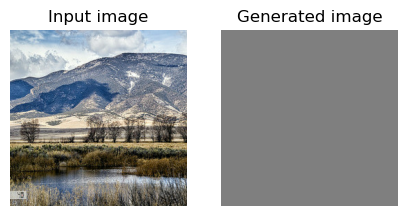

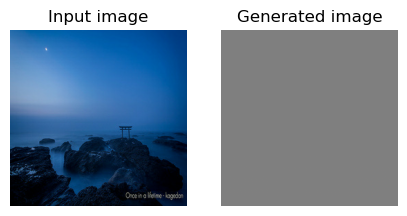

In [47]:
df = iter(photo_data)
for e in range(2):
        example_sample = next(df)
        generated_sample = generator(example_sample)
        
        f = plt.figure(figsize=(5, 5))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [49]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def gen_loss(out):
    return cross_entropy(tf.ones_like(out), out)

def disc_loss(out, fout):
    real_loss = cross_entropy(tf.ones_like(out), out)
    fake_loss = cross_entropy(tf.zeros_like(fout), fout)
    total_loss = real_loss + fake_loss
    return total_loss

In [50]:

EPOCHS = 2
sample_interval = EPOCHS / 10
BATCH_SIZE = 32

In [51]:
# Amy yang function
@tf.function
def train_step(image_batch):
    noise = tf.random.normal([1,256, 256, 3])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: 
        
        generated_image = generator(noise, training=True)

        discriminator_pred_gen = discriminator(generated_image, training=True)

        discriminator_pred_ori= discriminator(image_batch, training=True)


        discriminator_loss = cross_entropy(tf.ones_like(discriminator_pred_ori),discriminator_pred_ori) + cross_entropy(tf.zeros_like(discriminator_pred_gen), discriminator_pred_gen)
        generator_loss = cross_entropy(tf.ones_like(discriminator_pred_gen), discriminator_pred_gen)
        
    generator_grad = gen_tape.gradient(generator_loss, generator.trainable_variables)
    discriminator_grad = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    optimizer.apply_gradients(zip(generator_grad,generator.trainable_variables))
    optimizer.apply_gradients(zip(discriminator_grad,discriminator.trainable_variables))    

In [52]:

def train(dataset, epochs):
    for epoch in range(epochs):
        
        for image_batch in dataset:
            train_step(image_batch)

In [53]:
train(monet_data, EPOCHS)

Time for epoch 1 is : 188.25276637077332
Time for epoch 2 is : 183.72103261947632
